# Bangla Cyberbullying Binary Classification with LSTM

This notebook implements an LSTM model for binary classification of Bangla cyberbullying text (bullying vs. non-bullying).

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize
from bnlp import SentencepieceTokenizer
from bnlp.embedding.fasttext import BengaliFasttext
from sklearn.preprocessing import LabelEncoder
import time
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# Import TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## 1. Loading and Exploring Datasets

In [26]:
# 1. Load the datasets
print("Loading datasets...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")
only_augmented_cleaned_df = pd.read_csv("../../dataset/cleaned/only_augmented.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")
print(f"Augmented dataset shape: {only_augmented_cleaned_df.shape}")

Loading datasets...
Original dataset shape: (41907, 6)
Augmented dataset shape: (6081, 3)


In [27]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization

In [28]:
# Map the labels for binary classification (0 for 'not bully', 1 for all other classes)
def binary_label_mapping(label):
    return 0 if label == "not bully" else 1

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].apply(binary_label_mapping)
only_augmented_cleaned_df["label_encoded"] = only_augmented_cleaned_df["label"].apply(binary_label_mapping)

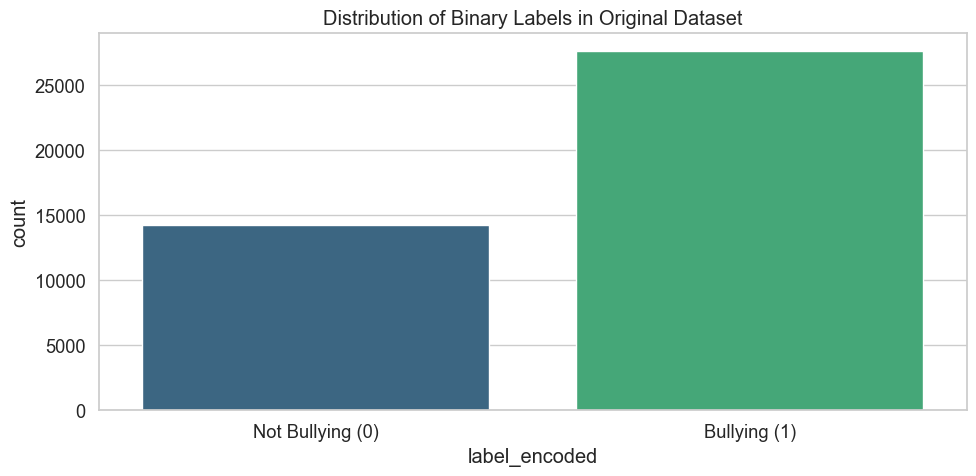

In [29]:
# Check the distribution of binary labels
plt.figure(figsize=(10, 5))
sns.countplot(x="label_encoded", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Binary Labels in Original Dataset")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.tight_layout()
plt.show()

## 3. Data Splitting and Augmentation

In [30]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size before augmentation: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size before augmentation: 33525
Test set size: 8382


In [31]:
# Add augmented data to the training set
X_aug = only_augmented_cleaned_df["text"]
y_aug = only_augmented_cleaned_df["label_encoded"]

# Concatenate original training data with augmented data
X_train_augmented = pd.concat([X_train, X_aug])
y_train_augmented = pd.concat([y_train, y_aug])

print(f"Training set size after augmentation: {len(X_train_augmented)}")

Training set size after augmentation: 39606


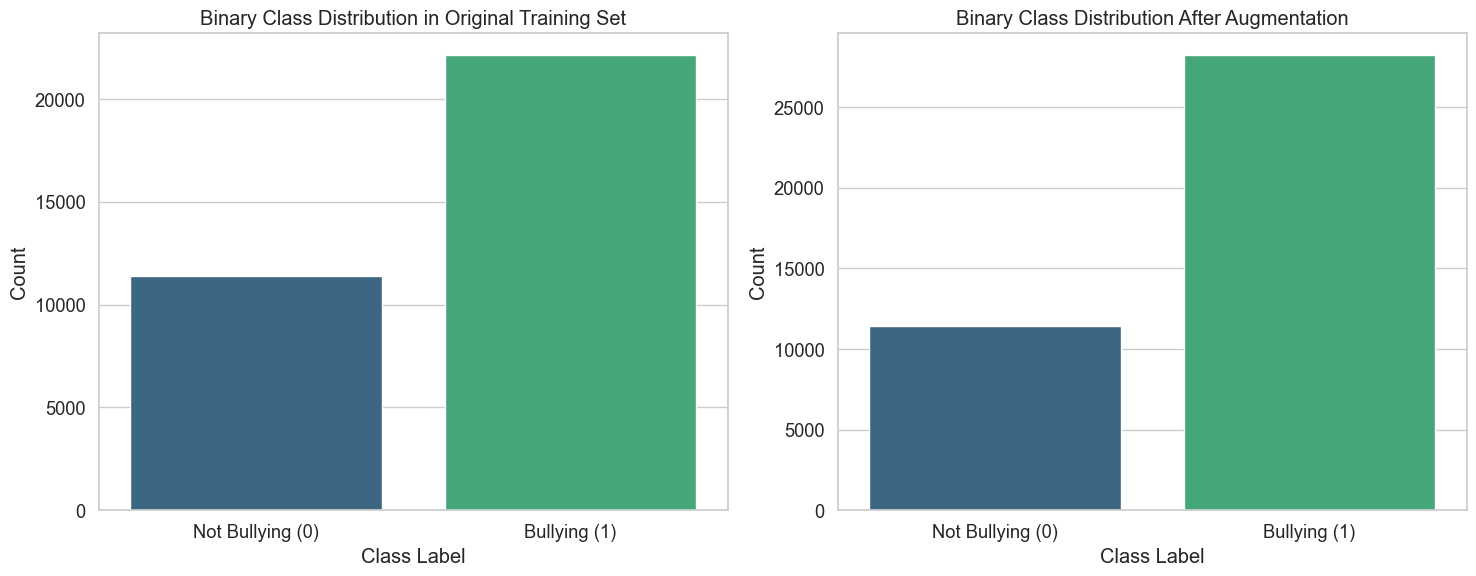

In [32]:
# Visualize the binary class distribution before and after augmentation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="viridis")
plt.title("Binary Class Distribution in Original Training Set")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_augmented, palette="viridis")
plt.title("Binary Class Distribution After Augmentation")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Sequence Preparation for LSTM

In [33]:
# Initialize Keras tokenizer for sequence preparation
print("Initializing Keras tokenizer...")
max_words = 10000  # Maximum number of words to keep, based on word frequency
max_sequence_length = 100  # Maximum length of each sequence

# Initialize and fit tokenizer on training data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_augmented)

Initializing Keras tokenizer...


In [34]:
# Convert texts to sequences and pad them to ensure uniform input size
def texts_to_sequences_and_pad(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    return padded_sequences

# Get vocabulary size for embedding layer
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 68590


In [35]:
# Convert and pad training sequences
print("Converting training data to sequences...")
start_time = time.time()
X_train_sequences = texts_to_sequences_and_pad(X_train_augmented)
print(
    f"Training data sequence preparation completed in {time.time() - start_time:.2f} seconds"
)
print(f"Training sequence shape: {X_train_sequences.shape}")

Converting training data to sequences...
Training data sequence preparation completed in 0.68 seconds
Training sequence shape: (39606, 100)


In [36]:
# Convert and pad testing sequences
print("Converting testing data to sequences...")
start_time = time.time()
X_test_sequences = texts_to_sequences_and_pad(X_test)
print(f"Testing data sequence preparation completed in {time.time() - start_time:.2f} seconds")
print(f"Testing sequence shape: {X_test_sequences.shape}")

Converting testing data to sequences...
Testing data sequence preparation completed in 0.16 seconds
Testing sequence shape: (8382, 100)


## 5. Building and Training LSTM Model

In [37]:
# Configure and build LSTM model
print("Building LSTM model...")
embedding_dim = 128  # Embedding dimension

# Define the LSTM model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.3))  # Apply dropout to prevent overfitting
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Bidirectional LSTM layer
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))  # Second LSTM layer
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='../../models/lstm/best_binary_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the LSTM model
print("Training LSTM model...")
batch_size = 32
epochs = 10

start_time = time.time()
history = model.fit(
    X_train_sequences,
    y_train_augmented,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training LSTM model...
Epoch 1/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7978 - loss: 0.4216
Epoch 1: val_loss improved from inf to 0.13651, saving model to ../../models/lstm/best_binary_lstm_model.h5


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 122s 105ms/step - accuracy: 0.7979 - loss: 0.4215 - val_accuracy: 0.9472 - val_loss: 0.1365
Epoch 2/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9051 - loss: 0.2251
Epoch 2: val_loss improved from 0.13651 to 0.12177, saving model to ../../models/lstm/best_binary_lstm_model.h5


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 111s 99ms/step - accuracy: 0.9051 - loss: 0.2251 - val_accuracy: 0.9434 - val_loss: 0.1218
Epoch 3/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9320 - loss: 0.1674
Epoch 3: val_loss did not improve from 0.12177
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 112s 100ms/step - accuracy: 0.9320 - loss: 0.1674 - val_accuracy: 0.9384 - val_loss: 0.1372
Epoch 4/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9448 - loss: 0.1346
Epoch 4: val_loss improved from 0.12177 to 0.11844, saving model to ../../models/lstm/best_binary_lstm_model.h5


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 114s 103ms/step - accuracy: 0.9448 - loss: 0.1346 - val_accuracy: 0.9523 - val_loss: 0.1184
Epoch 5/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9506 - loss: 0.1157
Epoch 5: val_loss did not improve from 0.11844
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 114s 102ms/step - accuracy: 0.9506 - loss: 0.1157 - val_accuracy: 0.9495 - val_loss: 0.1471
Epoch 6/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9570 - loss: 0.0975
Epoch 6: val_loss did not improve from 0.11844
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 116s 104ms/step - accuracy: 0.9570 - loss: 0.0975 - val_accuracy: 0.9498 - val_loss: 0.1620
Epoch 7/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9633 - loss: 0.0804
Epoch 7: val_loss did not improve from 0.11844
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 116s 104ms/step - accuracy: 0.9633 - loss: 0.0804 - val_accuracy: 0.9515 - val_loss: 0.1430
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
Model trained 

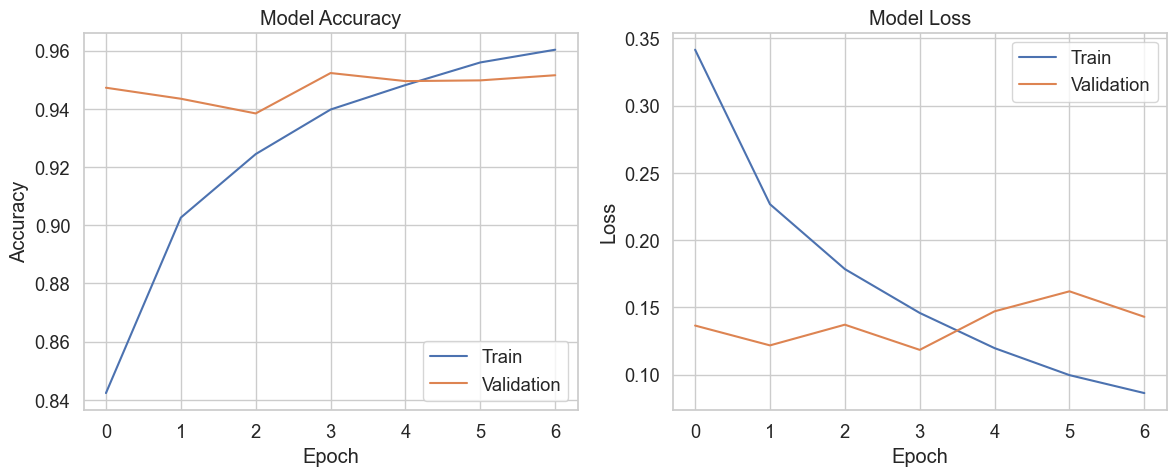

In [39]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 6. Model Evaluation - Basic Metrics

In [40]:
# Make predictions and calculate basic metrics
print("Evaluating model...")
# Get predicted probabilities
y_pred_proba = model.predict(X_test_sequences)
# Convert to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Accuracy: 0.8632
Precision: 0.8617
Recall: 0.8632
F1 Score: 0.8618


In [41]:
# Display classification report for binary classification
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Bullying", "Bullying"]))

Classification Report:
              precision    recall  f1-score   support

Not Bullying       0.82      0.76      0.79      2852
    Bullying       0.88      0.92      0.90      5530

    accuracy                           0.86      8382
   macro avg       0.85      0.84      0.84      8382
weighted avg       0.86      0.86      0.86      8382



## 7. Confusion Matrix Visualization

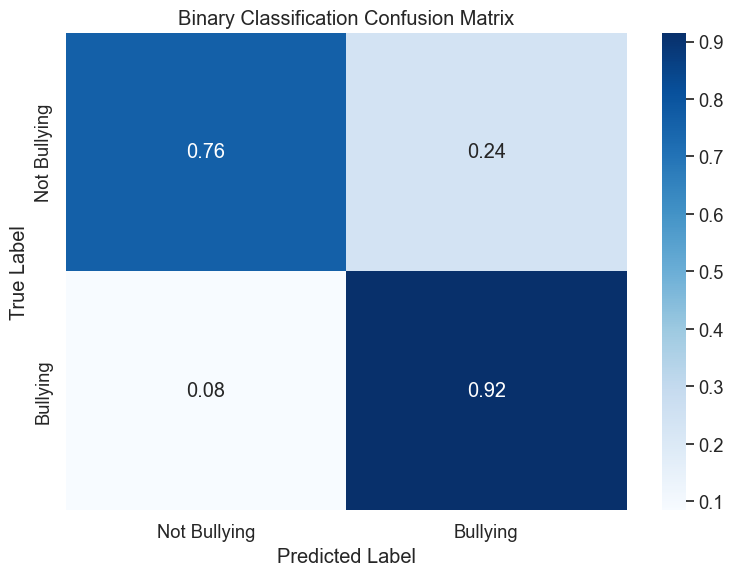

In [42]:
# Create and display confusion matrix for binary classification
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Not Bullying", "Bullying"],
    yticklabels=["Not Bullying", "Bullying"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Binary Classification Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. Model Attention Analysis

262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


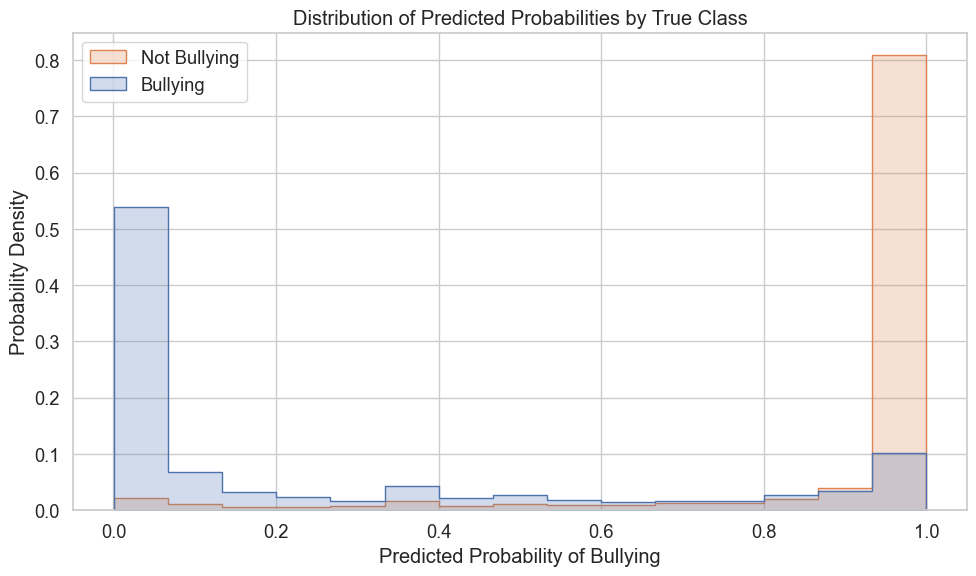

In [43]:
# For LSTM models, we don't have direct feature importance like in Random Forest
# Instead, let's analyze model performance on different classes

# Get prediction probabilities for each class
y_pred_probabilities = model.predict(X_test_sequences)

# Create a DataFrame with actual labels and predicted probabilities
prediction_df = pd.DataFrame({
    'actual_label': y_test,
    'predicted_probability': y_pred_probabilities.flatten()
})

# Visualize the distribution of predicted probabilities by actual class
plt.figure(figsize=(10, 6))
sns.histplot(data=prediction_df, x='predicted_probability', hue='actual_label', 
             element='step', stat='probability', common_norm=False)
plt.title('Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability of Bullying')
plt.ylabel('Probability Density')
plt.legend(labels=['Not Bullying', 'Bullying'])
plt.tight_layout()
plt.show()

## 9. ROC Curve Analysis

262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


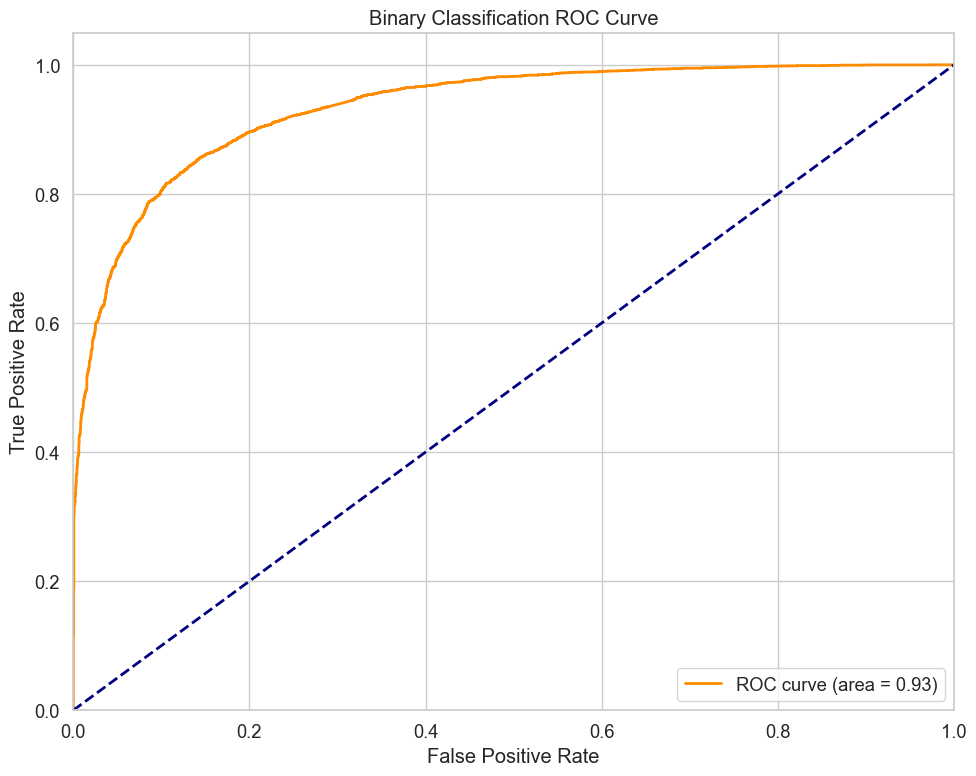

In [44]:
# ROC Curve and AUC for binary classification
y_score = model.predict(X_test_sequences).flatten()  # Probability of positive class

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Classification ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis

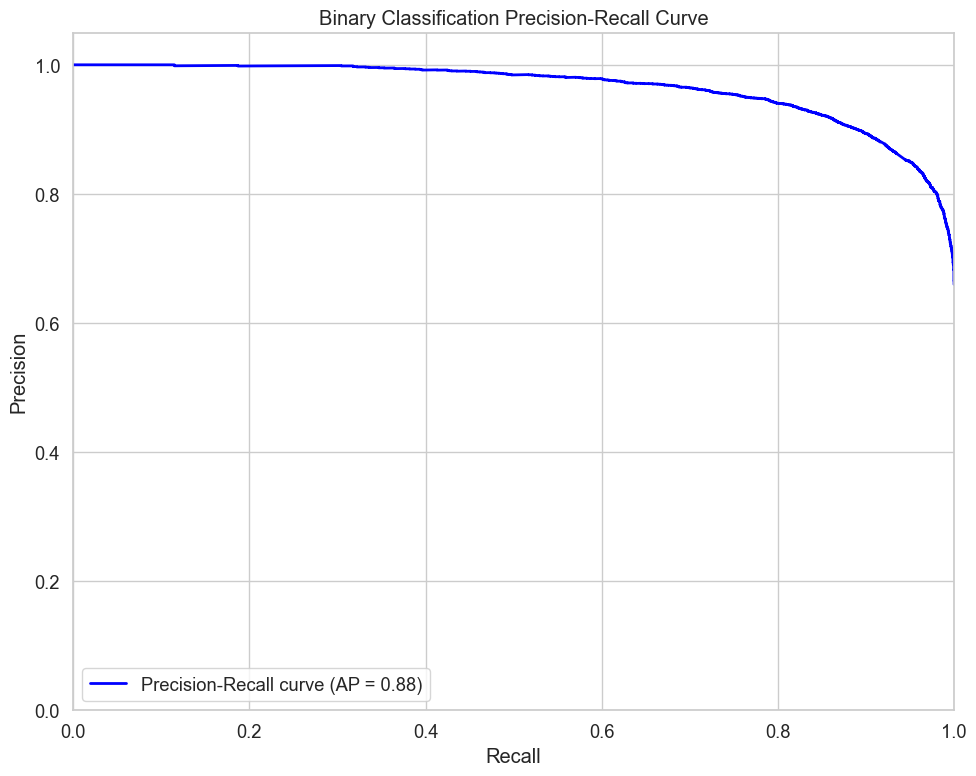

In [45]:
# Calculate Precision-Recall curve for binary classification
precision, recall, _ = precision_recall_curve(y_test, y_score)
avg_precision = precision_score(y_test, y_pred)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Classification Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 12. Model Summary and Saving

In [46]:
# Summary of the binary classification model
print("Binary Classification LSTM Model Summary:")
print(f"Total samples in training set (with augmentation): {len(X_train_augmented)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Maximum sequence length: {max_sequence_length}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
plt.show()

Binary Classification LSTM Model Summary:
Total samples in training set (with augmentation): 39606
Total samples in test set: 8382
Vocabulary size: 68590
Maximum sequence length: 100
Final model accuracy on test set: 0.8632


In [47]:
# Save the model
model.save("../../models/lstm/binary_lstm_model.h5")
print("Model saved successfully")

# Save tokenizer for later use with the model
import pickle
with open("../../models/lstm/binary_tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved successfully")

Model saved successfully
Tokenizer saved successfully
